In [74]:
import numpy as np
from PIL import Image
import time
from scipy.ndimage import generic_filter
import matplotlib.pyplot as plt
import timeit
import numpy as np

CPU Time taken with omega = 3: 233.4163 seconds


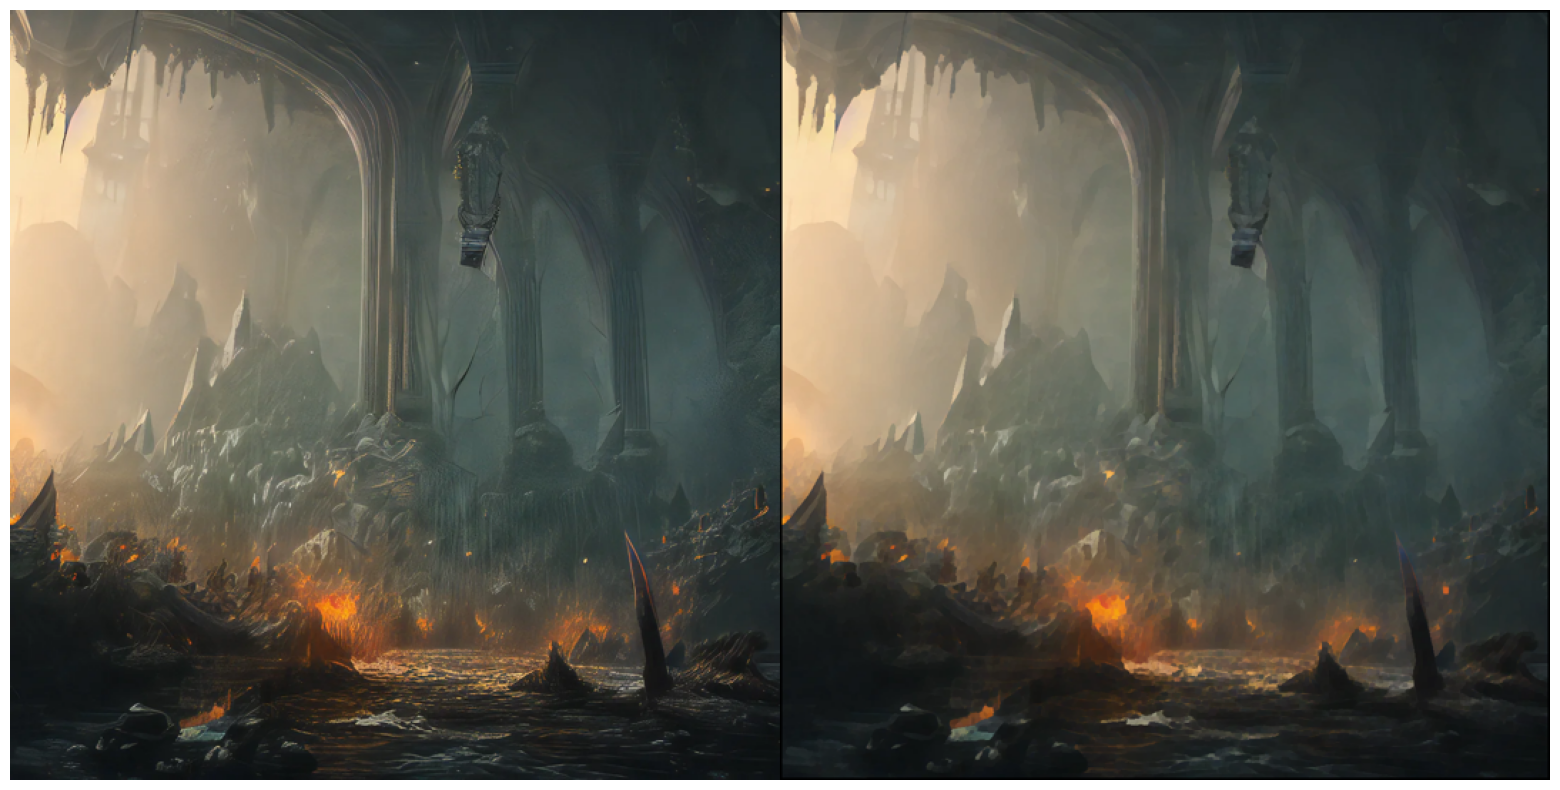

In [ ]:
def kuwahara_region_filter(region, omega):
    region = np.reshape(region, (omega * 2 + 1, omega * 2 + 1, 3))

    min_variance = float('inf')
    best_mean = np.zeros(3)

    quadrants = [
        region[:omega+1, :omega+1],
        region[:omega+1, omega:],
        region[omega:, :omega+1],
        region[omega:, omega:]
    ]

    for quadrant in quadrants:
        mean = quadrant.mean(axis=(0, 1))
        variance = quadrant.var(axis=(0, 1)).sum()

        if variance < min_variance:
            min_variance = variance
            best_mean = mean

    return best_mean

def apply_kuwahara_filter(image, omega):
    height, width, _ = image.shape
    output_image = np.zeros_like(image)

    for y in range(omega, height - omega):
        for x in range(omega, width - omega):
            region = image[y - omega:y + omega + 1, x - omega:x + omega + 1]
            output_image[y, x] = kuwahara_region_filter(region, omega)

    return output_image

image_path = 'src/photo.png'
image = Image.open(image_path).convert("RGB")
image_rgb = np.array(image)

omega = 3
start_time = time.time()
filtered_image = apply_kuwahara_filter(image_rgb, omega)
end_time = time.time()
print(f"CPU Time taken with omega = {omega}: {end_time - start_time:.4f} seconds")

height, width = image_rgb.shape[:2]
filtered_image_resized = np.array(Image.fromarray(filtered_image).resize((width // 2, height // 2)))
image_rgb_resized = np.array(image.resize((width // 2, height // 2)))

concatenated_image = np.concatenate((image_rgb_resized, filtered_image_resized), axis=1)
plt.figure(figsize=(20, 10))
plt.imshow(concatenated_image)
plt.axis('off')
plt.show()

In [76]:
def benchmark_kuwahara_filter(function, image, omega_values):
    performance_results = {}

    for omega in omega_values:
        execution_time = timeit.timeit(lambda: function(image, omega), number=1)
        performance_results[omega] = execution_time

    return performance_results

omega_range = [1, 2, 4, 8, 16]
performance_data = benchmark_kuwahara_filter(apply_kuwahara_filter, image_rgb, omega_range)

print("\nPerformance Timing Results for Different Omega Values:")
for omega, time_taken in performance_data.items():
    print(f"Time taken with omega = {omega}: {time_taken:.4f} seconds")


Performance Timing Results for Different Omega Values:
Time taken with omega = 1: 234.3989 seconds
Time taken with omega = 2: 230.8377 seconds
Time taken with omega = 4: 238.6367 seconds
Time taken with omega = 8: 260.2265 seconds
Time taken with omega = 16: 306.1300 seconds


GPU sync Time taken with omega = 3: 0.4733 seconds


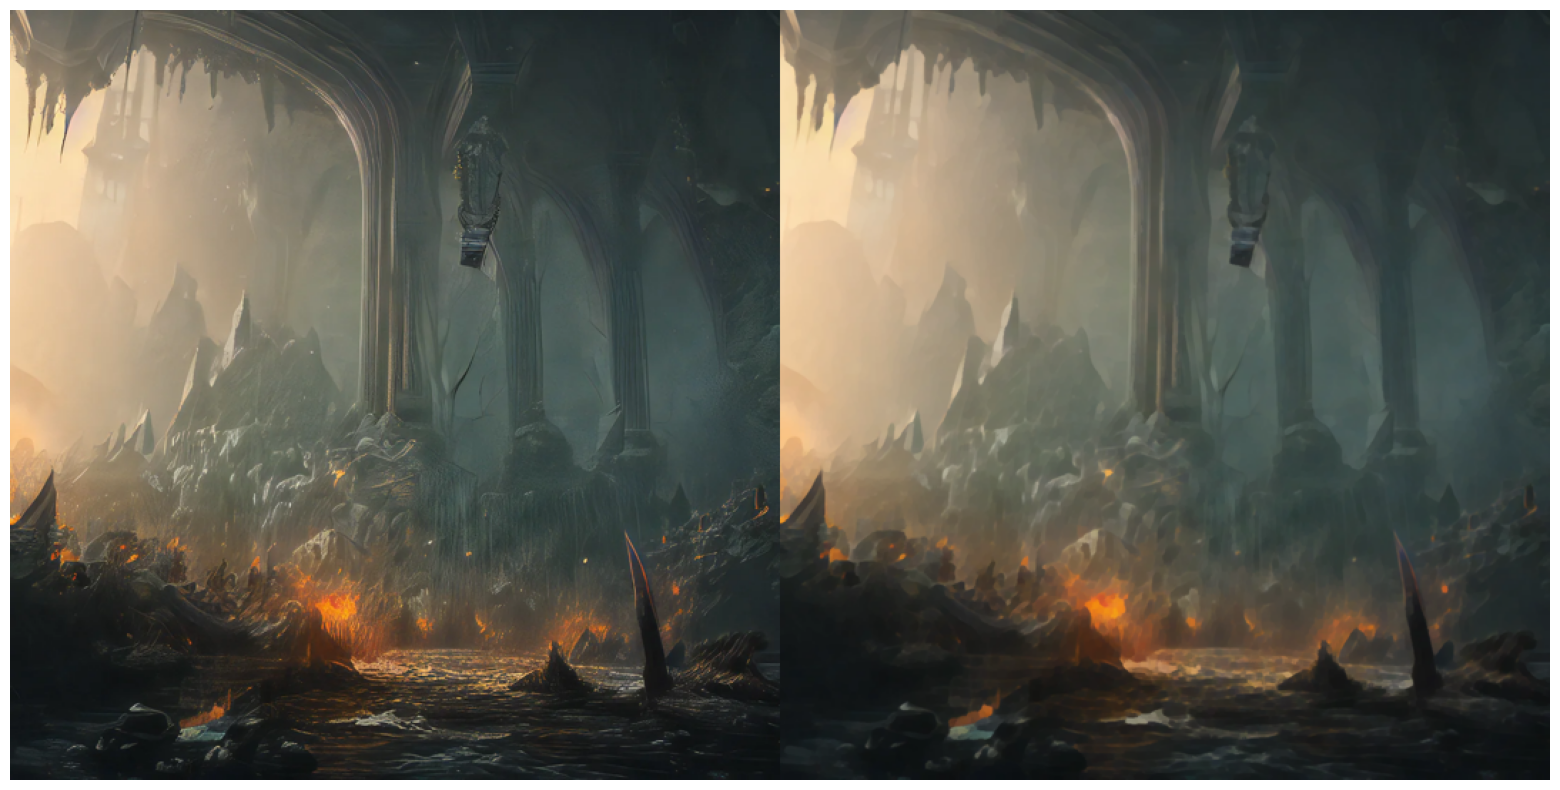

In [ ]:
@cuda.jit
def kuwahara_filter(input_img, output_img, img_height, img_width, radius):
    x, y = cuda.grid(2)

    if x < img_width and y < img_height:
        best_variance = float('inf')
        best_avg = (0.0, 0.0, 0.0)

        for quadrant_y in range(2):
            for quadrant_x in range(2):
                sum_r = 0.0
                sum_g = 0.0
                sum_b = 0.0
                sum_r_sq = 0.0
                sum_g_sq = 0.0
                sum_b_sq = 0.0
                count = 0

                for dy in range(-radius, radius + 1):
                    for dx in range(-radius, radius + 1):
                        nx = x + dx + quadrant_x * radius
                        ny = y + dy + quadrant_y * radius
                        if 0 <= nx < img_width and 0 <= ny < img_height:
                            r, g, b = input_img[ny, nx]
                            sum_r += r
                            sum_g += g
                            sum_b += b
                            sum_r_sq += r ** 2
                            sum_g_sq += g ** 2
                            sum_b_sq += b ** 2
                            count += 1

                if count > 0:
                    mean_r = sum_r / count
                    mean_g = sum_g / count
                    mean_b = sum_b / count

                    var_r = (sum_r_sq / count) - (mean_r ** 2)
                    var_g = (sum_g_sq / count) - (mean_g ** 2)
                    var_b = (sum_b_sq / count) - (mean_b ** 2)
                    total_variance = var_r + var_g + var_b

                    if total_variance < best_variance:
                        best_variance = total_variance
                        best_avg = (mean_r, mean_g, mean_b)

        output_img[y, x] = best_avg

def apply_kuwahara_filter(image, radius):
    input_img = np.array(image, dtype=np.float32)
    img_height, img_width, _ = input_img.shape

    output_img = np.zeros_like(input_img)

    input_img_device = cuda.to_device(input_img)
    output_img_device = cuda.to_device(output_img)

    threads_per_block = (16, 16)
    blocks_per_grid = ((img_width + threads_per_block[0] - 1) // threads_per_block[0],
                       (img_height + threads_per_block[1] - 1) // threads_per_block[1])

    kuwahara_filter[blocks_per_grid, threads_per_block](input_img_device, output_img_device, img_height, img_width, radius)
    cuda.synchronize()

    output_img = output_img_device.copy_to_host().astype(np.uint8)
    return Image.fromarray(output_img)


image_path = 'src/photo.png'
image = Image.open(image_path).convert("RGB")

omega = 3
start_time = time.time()
filtered_image = apply_kuwahara_filter(image, omega)
end_time = time.time()
print(f"GPU sync Time taken with omega = {omega}: {end_time - start_time:.4f} seconds")

image_resized = image.resize((image.width // 2, image.height // 2))
filtered_image_resized = filtered_image.resize((image.width // 2, image.height // 2))

concatenated_image = np.concatenate((np.array(image_resized), np.array(filtered_image_resized)), axis=1)
plt.figure(figsize=(20, 10))
plt.imshow(concatenated_image)
plt.axis('off')
plt.show()

In [78]:
omega_range = [1, 2, 4, 8, 16]
performance_data = benchmark_kuwahara_filter(apply_kuwahara_filter, image_rgb, omega_range)

print("\nPerformance Timing Results for Different Omega Values:")
for omega, time_taken in performance_data.items():
    print(f"Time taken with omega = {omega}: {time_taken:.4f} seconds")


Performance Timing Results for Different Omega Values:
Time taken with omega = 1: 0.0418 seconds
Time taken with omega = 2: 0.0596 seconds
Time taken with omega = 4: 0.1299 seconds
Time taken with omega = 8: 0.2056 seconds
Time taken with omega = 16: 0.5644 seconds


GPU Time taken with omega = 3: 0.7568 seconds


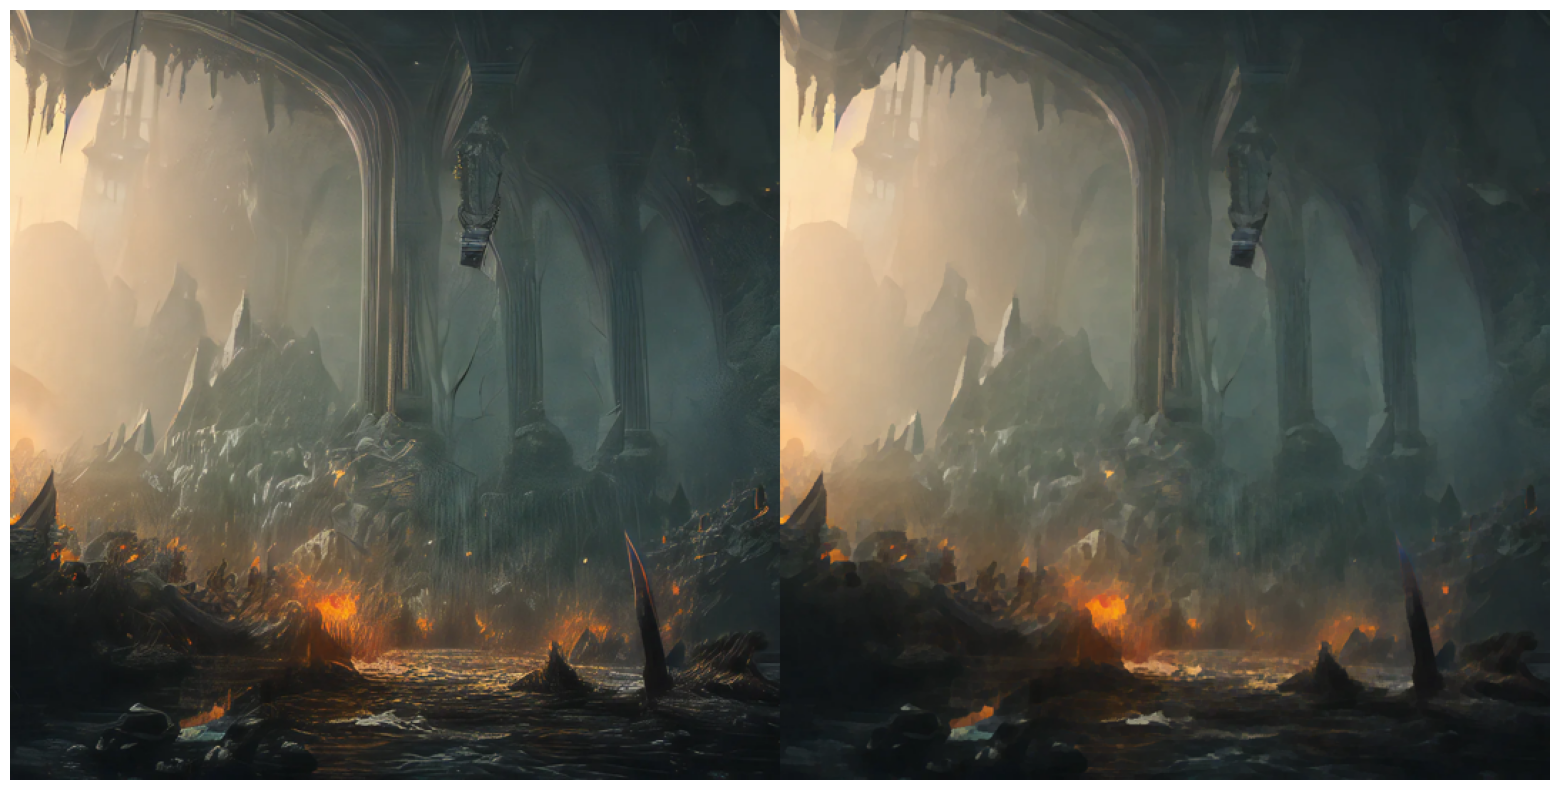

In [ ]:
@cuda.jit
def kuwahara_filter_shared_memory(input_r, input_g, input_b, output_r, output_g, output_b, height, width, omega):
    x, y = cuda.grid(2)

    if x >= width or y >= height:
        return

    shared_r = cuda.shared.array((16, 16), dtype=numba.float32)
    shared_g = cuda.shared.array((16, 16), dtype=numba.float32)
    shared_b = cuda.shared.array((16, 16), dtype=numba.float32)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    if x < width and y < height:
        shared_r[ty, tx] = input_r[y, x]
        shared_g[ty, tx] = input_g[y, x]
        shared_b[ty, tx] = input_b[y, x]
    else:
        shared_r[ty, tx] = 0.0
        shared_g[ty, tx] = 0.0
        shared_b[ty, tx] = 0.0

    cuda.syncthreads()

    avg_r = cuda.local.array(4, dtype=numba.float32)
    avg_g = cuda.local.array(4, dtype=numba.float32)
    avg_b = cuda.local.array(4, dtype=numba.float32)
    var_r = cuda.local.array(4, dtype=numba.float32)
    var_g = cuda.local.array(4, dtype=numba.float32)
    var_b = cuda.local.array(4, dtype=numba.float32)
    counts = cuda.local.array(4, dtype=numba.int32)

    for dx in range(-omega, omega + 1):
        for dy in range(-omega, omega + 1):
            ni, nj = y + dy, x + dx
            if 0 <= ni < height and 0 <= nj < width:
                r_value = input_r[ni, nj]
                g_value = input_g[ni, nj]
                b_value = input_b[ni, nj]

                if dy <= 0 and dx <= 0:
                    quadrant = 0
                elif dy <= 0 and dx >= 0:
                    quadrant = 1
                elif dy >= 0 and dx <= 0:
                    quadrant = 2
                else:
                    quadrant = 3

                avg_r[quadrant] += r_value
                avg_g[quadrant] += g_value
                avg_b[quadrant] += b_value
                var_r[quadrant] += r_value * r_value
                var_g[quadrant] += g_value * g_value
                var_b[quadrant] += b_value * b_value
                counts[quadrant] += 1

    min_variance = float('inf')
    selected_quadrant = 0
    for k in range(4):
        if counts[k] > 0:
            avg_r[k] /= counts[k]
            avg_g[k] /= counts[k]
            avg_b[k] /= counts[k]
            var_r[k] = (var_r[k] / counts[k]) - (avg_r[k] ** 2)
            var_g[k] = (var_g[k] / counts[k]) - (avg_g[k] ** 2)
            var_b[k] = (var_b[k] / counts[k]) - (avg_b[k] ** 2)

            total_variance = var_r[k] + var_g[k] + var_b[k]
            if total_variance < min_variance:
                min_variance = total_variance
                selected_quadrant = k

    if x < width and y < height:
        output_r[y, x] = avg_r[selected_quadrant]
        output_g[y, x] = avg_g[selected_quadrant]
        output_b[y, x] = avg_b[selected_quadrant]


def apply_kuwahara_filter_shared_memory(image, omega):
    input_img = np.array(image, dtype=np.float32)
    img_height, img_width, _ = input_img.shape

    r, g, b = input_img[:, :, 0], input_img[:, :, 1], input_img[:, :, 2]

    r_gpu = cuda.to_device(np.ascontiguousarray(r))
    g_gpu = cuda.to_device(np.ascontiguousarray(g))
    b_gpu = cuda.to_device(np.ascontiguousarray(b))

    output_r_gpu = cuda.device_array_like(r_gpu)
    output_g_gpu = cuda.device_array_like(g_gpu)
    output_b_gpu = cuda.device_array_like(b_gpu)

    threads_per_block = (16, 16)
    blocks_per_grid = ((img_width + threads_per_block[0] - 1) // threads_per_block[0],
                       (img_height + threads_per_block[1] - 1) // threads_per_block[1])

    kuwahara_filter_shared_memory[blocks_per_grid, threads_per_block](r_gpu, g_gpu, b_gpu, output_r_gpu, output_g_gpu, output_b_gpu, img_height, img_width, omega)
    cuda.synchronize()

    filtered_r = output_r_gpu.copy_to_host().astype(np.uint8)
    filtered_g = output_g_gpu.copy_to_host().astype(np.uint8)
    filtered_b = output_b_gpu.copy_to_host().astype(np.uint8)

    filtered_image = np.dstack((filtered_r, filtered_g, filtered_b))

    return Image.fromarray(filtered_image)

image_path = 'src/photo.png'
image = Image.open(image_path).convert("RGB")

omega = 3
start_time = time.time()
filtered_image = apply_kuwahara_filter_shared_memory(image, omega)
end_time = time.time()

print(f"GPU Time taken with omega = {omega}: {end_time - start_time:.4f} seconds")

image_resized = image.resize((image.width // 2, image.height // 2))
filtered_image_resized = filtered_image.resize((image.width // 2, image.height // 2))

concatenated_image = np.concatenate((np.array(image_resized), np.array(filtered_image_resized)), axis=1)
plt.figure(figsize=(20, 10))
plt.imshow(concatenated_image)
plt.axis('off')
plt.show()

In [80]:
omega_range = [1, 2, 4, 8, 16]
performance_data = benchmark_kuwahara_filter(apply_kuwahara_filter_shared_memory, image_rgb, omega_range)

print("\nPerformance Timing Results for Different Omega Values:")
for omega, time_taken in performance_data.items():
    print(f"Time taken with omega = {omega}: {time_taken:.4f} seconds")


Performance Timing Results for Different Omega Values:
Time taken with omega = 1: 0.0353 seconds
Time taken with omega = 2: 0.0303 seconds
Time taken with omega = 4: 0.0382 seconds
Time taken with omega = 8: 0.0516 seconds
Time taken with omega = 16: 0.1276 seconds
